In [11]:
from pathlib import Path
import os
import sys

dirname = Path(os.path.abspath(''))
root = dirname.parent

sys.path.insert(0, str(root))

In [12]:
BATCH_SIZE = 64
WINDOW_SIZE = 10
ENCODER_HIDDEN_STATES = 128
DECODER_HIDDEN_STATES = 128

Y_DIM = 1

DATA = 'nasdaq100_padding.csv'

VALIDATION_RATIO = 0.2

EPOCHS = 100

In [13]:
import numpy as np
import pandas as pd
from typing import Tuple
from sklearn.preprocessing import StandardScaler


def read_data(input_path: Path) -> Tuple[np.ndarray, np.ndarray]:
    """
    Read nasdaq stocks data.

    Args:
        input_path (str): directory to nasdaq dataset.

    Returns:
        X (np.ndarray): features.
        y (np.ndarray): ground truth.
    """
    df = pd.read_csv(input_path)

    X = df.loc[:, [x for x in df.columns if x != 'NDX']].values

    y = np.array(df['NDX'])

    return X, y

X, Y = read_data(DATA)

Y = Y[:, None]

features = np.concatenate((X, Y), axis=-1)

print(features.shape)

scale = StandardScaler().fit(features)
features = scale.transform(features)

features

(40560, 82)


array([[-0.82166581, -3.42991957, -1.60918711, ..., -1.86674079,
        -2.14183171, -2.35353513],
       [-0.83220311, -3.40824969, -1.60918711, ..., -1.81032478,
        -2.06400103, -2.35353513],
       [-0.83792335, -3.3938031 , -1.66989855, ..., -1.70183245,
        -2.05801406, -2.34133626],
       ...,
       [ 1.87717227,  1.16289176,  0.06697655, ...,  3.04774477,
        -1.84344086,  1.7048016 ],
       [ 1.88362367,  1.1737267 ,  0.07753506, ...,  3.0501316 ,
        -1.84547643,  1.72163035],
       [ 1.88362367,  1.17131893,  0.0722558 , ...,  3.05447129,
        -1.84248294,  1.72151974]])

In [18]:
def get_labels_from_features(features):
    return features[WINDOW_SIZE - 1:, -Y_DIM:][:, None, :]


def split_by_ratio(features):
    length = len(features)
    validation_length = int(VALIDATION_RATIO * length)
    
    return features[:-validation_length], features[-validation_length:]


training_features, validation_features = split_by_ratio(features)

print('training length', len(training_features))
print('validation length', len(validation_features))

training length 32448
validation length 8112


In [19]:
import tensorflow as tf
from get_rolling_window import rolling_window

train_f, train_l = rolling_window(training_features, WINDOW_SIZE, 1), get_labels_from_features(training_features)
train_ds = tf.data.Dataset.from_tensor_slices((train_f, train_l)).batch(BATCH_SIZE, drop_remainder=True)

print(train_f.shape, train_l.shape)

val_f, val_l = rolling_window(validation_features, WINDOW_SIZE, 1), get_labels_from_features(validation_features)
val_ds = tf.data.Dataset.from_tensor_slices((val_f, val_l)).batch(BATCH_SIZE, drop_remainder=True)

train_ds

(32439, 10, 82) (32439, 1, 1)


<BatchDataset shapes: ((64, 10, 82), (64, 1, 1)), types: (tf.float64, tf.float64)>

In [35]:
from da_rnn import DARNN
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Reshape

model = DARNN(
    WINDOW_SIZE,
    ENCODER_HIDDEN_STATES,
    DECODER_HIDDEN_STATES,
    Y_DIM
)

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae', 'mape']
)

In [36]:
feature_batch, label_batch = next(iter(train_ds))

print('feature, label shape', feature_batch.shape, label_batch.shape)

print('prediction shape', model(feature_batch).shape)

model(feature_batch[:1])

feature, label shape (64, 10, 82) (64, 1, 1)
prediction shape (64, 1, 1)


<tf.Tensor: shape=(1, 1, 1), dtype=float32, numpy=array([[[-0.00859012]]], dtype=float32)>

In [37]:
save_to = dirname / 'checkpoint.hdf5'

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[
        # Save checkpoints on best validation loss
        tf.keras.callbacks.ModelCheckpoint(
            save_to,
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        # Stop early if the model overfits
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    ],
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/100
506/506 [==============================] - 47s 58ms/step - loss: 0.4080 - mae: 0.3784 - mape: 109.2760 - val_loss: 0.1271 - val_mae: 0.3084 - val_mape: 29.2473

Epoch 00001: val_loss improved from inf to 0.12713, saving model to /Users/kael/Codes/ml/tensorflow-2-DA-RNN/notebook/checkpoint.hdf5
Epoch 2/100
506/506 [==============================] - 26s 50ms/step - loss: 0.0477 - mae: 0.1065 - mape: 26.3498 - val_loss: 0.0244 - val_mae: 0.1187 - val_mape: 16.5335

Epoch 00002: val_loss improved from 0.12713 to 0.02444, saving model to /Users/kael/Codes/ml/tensorflow-2-DA-RNN/notebook/checkpoint.hdf5
Epoch 3/100
506/506 [==============================] - 24s 48ms/step - loss: 0.0187 - mae: 0.0772 - mape: 25.5851 - val_loss: 0.0150 - val_mae: 0.0903 - val_mape: 13.6669

Epoch 00003: val_loss improved from 0.02444 to 0.01502, saving model to /Users/kael/Codes/ml/tensorflow-2-DA-RNN/notebook/checkpoint.hdf5
Epoch 4/100
506/506 [==============================] - 26s 51ms/step - lo

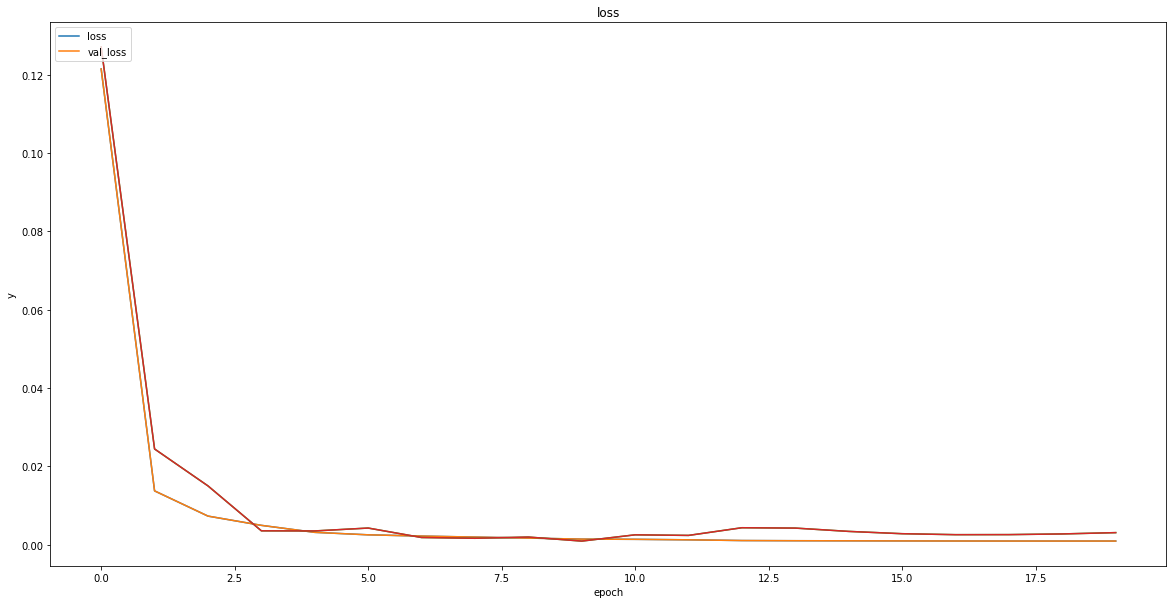

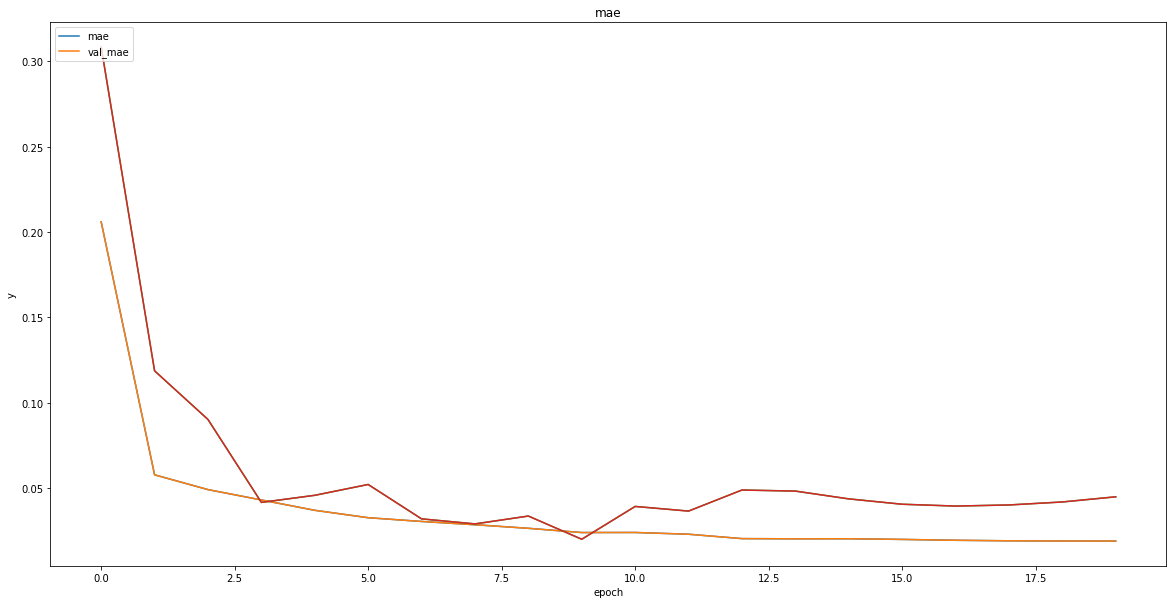

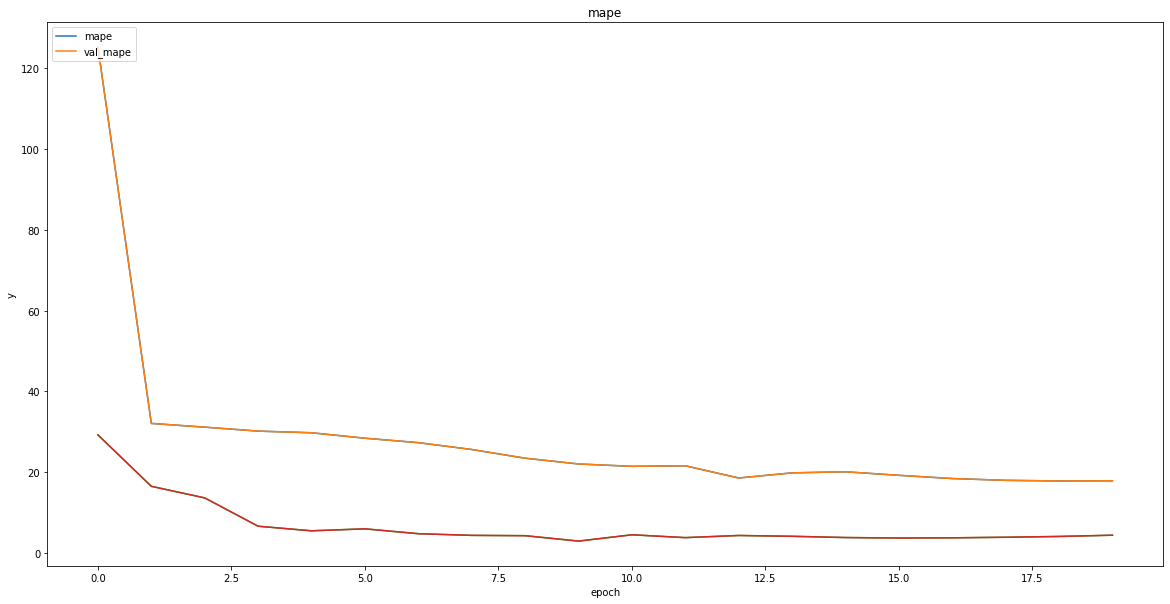

In [38]:
import matplotlib.pyplot as plt


def plot(keys, title='title', ylabel='y'):
    for key in keys:
        plt.plot(history.history[key])
        plt.plot(history.history[key])
        
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('epoch')
    
    plt.legend(keys, loc='upper left')
    
    plt.show()
    
plot(['loss', 'val_loss'], 'loss')
plot(['mae', 'val_mae'], 'mae')
plot(['mape', 'val_mape'], 'mape')


In [34]:
pred = model(val_f)

print(val_f.shape, pred.shape)

pred

(8103, 10, 82) (8103, 1, 1)


<tf.Tensor: shape=(8103, 1, 1), dtype=float32, numpy=
array([[[0.9461817]],

       [[0.9388566]],

       [[0.9410234]],

       ...,

       [[1.7317458]],

       [[1.7357172]],

       [[1.7540205]]], dtype=float32)>

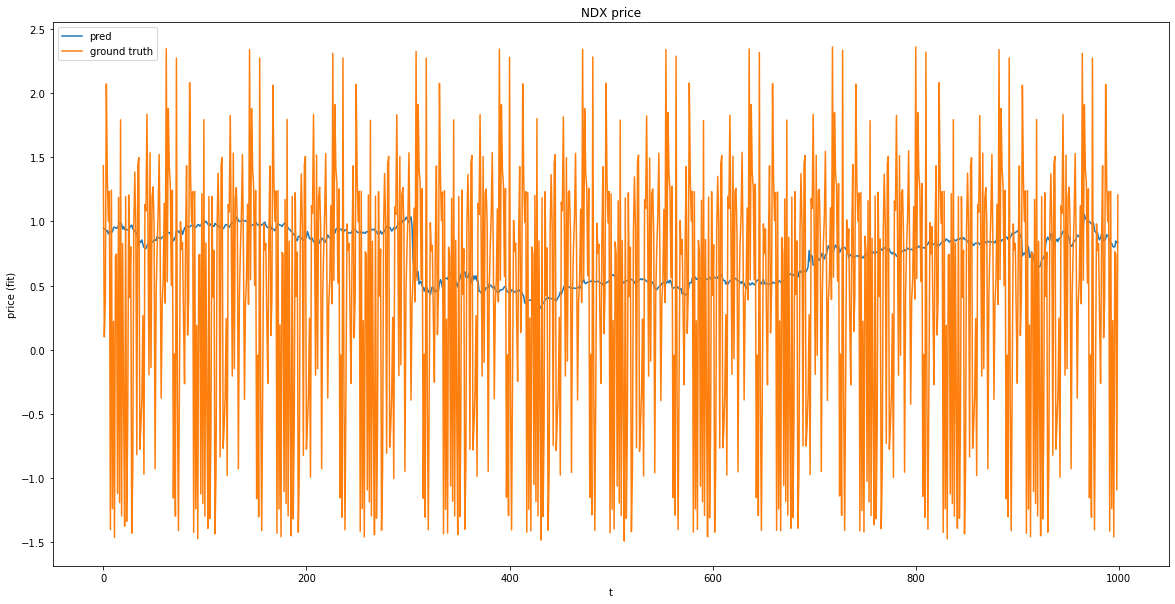

In [39]:
plt.figure(figsize=(20,10))

plt.plot(pred.numpy().flatten()[:1000])
plt.plot(val_f.flatten()[:1000])

plt.title('NDX price')
plt.ylabel('price (fit)')
plt.xlabel('t')

plt.legend(['pred', 'ground truth'], loc='upper left')

plt.show()